In [7]:
import torch
from datasets import IndexedDataset, WeightedDataset, load_data
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss, apgd_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, add_lora, set_lora_gradients #load_statedict

import torch.nn as nn

args = get_args()
args.arch = 'convnext'
args.dataset = 'Aircraft'
args.selection_method = 'random'
args.aug = 'aug'
args.pre_trained = 'imagenet1k_non_robust'
args.loss_function = 'APGD'

args.iterations = 20
args.pruning_ratio = 0.99
args.delta = 1
args.batch_size = 24
args.pruning_strategy = 'fixed_stratified'
args.batch_strategy = 'random'
args.sample_size= 128
args.init_lr = 0.001

# Example Usage

# model = load_architecture(args)

# state_dict = torch.load('./state_dicts/convnext_tiny_22k_224.pth')
# model.load_state_dict(state_dict)
# model, target_layers = load_architecture(args)
# add_lora(args, model, target_layers)
# set_lora_gradients(args, model, target_layers)

# model.to('cuda')

# train_dataset, val_dataset, test_dataset, N, transform = load_data(args) 

# train_dataset = WeightedDataset(args, train_dataset, transform, N, prune_ratio = args.pruning_ratio,  )

# train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=2, rank=0, drop_last=True)

# trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler, ) #

./data


In [19]:
import pandas as pd
df = pd.DataFrame(columns=key_columns + ['timestamp', 'clean_acc', 'robust_acc'])
df.empty

True

In [4]:
import pandas as pd

# Convert argparse.Namespace to a dictionary
args_dict = vars(args)

# Convert the dictionary to a DataFrame
df = pd.DataFrame([args_dict])

df

,arch,pre_trained,lora,dataset,pruning_strategy,pruning_ratio,batch_strategy,aug,iterations,delta,...,num_workers,epsilon,step_size,perturb_steps,beta,distance,unsup_fraction,exp,device,selection_method
0,convnext,imagenet1k_non_robust,None,Aircraft,fixed_stratified,0.99,random,aug,20,1,...,1,0.015686,0.007843,10,1.0,l_inf,0.3,,cuda,random


In [17]:
list( args_dict.keys() )

['arch',
 'pre_trained',
 'lora',
 'dataset',
 'pruning_strategy',
 'pruning_ratio',
 'batch_strategy',
 'aug',
 'iterations',
 'delta',
 'batch_size',
 'sample_size',
 'loss_function',
 'init_lr',
 'sched',
 'momentum',
 'weight_decay',
 'seed',
 'log_dir',
 'statedict_dir',
 'data_dir',
 'task',
 'num_workers',
 'epsilon',
 'step_size',
 'perturb_steps',
 'beta',
 'distance',
 'unsup_fraction',
 'exp',
 'device',
 'selection_method']

In [11]:
import pandas as pd
import numpy as np

def experiment_exists(df, current_experiment, key_columns, tol=1e-6):
    """
    Check if the current experiment already exists in the DataFrame based on key columns.

    Parameters:
    df (pd.DataFrame): The DataFrame containing previous experiments.
    current_experiment (dict): The arguments of the current experiment as a dictionary.
    key_columns (list): The list of columns to use as the key for comparison.
    tol (float): Tolerance for floating-point comparison.

    Returns:
    bool: True if the experiment exists based on key columns, False otherwise.
    """
    # Filter the DataFrame to only include the key columns
    df_key = df[key_columns]

    # Convert the current experiment to a DataFrame with only the key columns
    current_experiment_key = {k: current_experiment[k] for k in key_columns}
    current_df_key = pd.DataFrame([current_experiment_key])

    # Adjust for floating-point comparisons
    matches = []
    for col in key_columns:
        if df_key[col].dtype.kind in 'fc':  # if column is float or complex
            match_series = pd.Series(np.isclose(df_key[col], current_df_key[col].iloc[0], atol=tol))
        else:
            match_series = df_key[col] == current_df_key[col].iloc[0]
        matches.append(match_series)

    # Combine all conditions and check if any row matches completely
    exists = pd.concat(matches, axis=1).all(axis=1).any()

    return exists

# Example usage
# Assume df is your existing DataFrame with experiment results, including a "final_performance" column
df = pd.DataFrame([
    {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'final_performance': 0.85},
    {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'final_performance': 0.9}
])

# Current experiment as a dictionary
current_experiment = {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}

# Define the key columns to check for experiment existence
key_columns = ['learning_rate', 'batch_size', 'epochs']

# Check if the experiment exists based on key columns
exists = experiment_exists(df, current_experiment, key_columns)
print(f"Experiment exists based on key columns: {exists}")


KeyError: 'final_performance'

In [8]:
train_dataset

Dataset FGVCAircraft
    Number of datapoints: 3334
    Root location: ./data

In [32]:
import timm

from timm.models import create_model

model = timm.create_model('convnext_tiny.fb_in22k', pretrained=True)
model_save_path = "./state_dicts/test.pth"
torch.save(model.state_dict(), model_save_path)

state_dict = torch.load('./state_dicts/test.pth')
model = timm.models.convnext.convnext_tiny(pretrained=False)
num_features = model.head.fc.in_features
model.head.fc = nn.Linear(num_features, 21841)  
model.load_state_dict(state_dict)

In [1]:
import math

def adjust_epochs(original_data_size, pruned_data_size, batch_size, original_epochs):

    # Calculate the total number of iterations with the original data
    original_iterations_per_epoch = math.ceil(original_data_size / batch_size)
    total_iterations_original = original_iterations_per_epoch * original_epochs

    # Calculate the number of iterations per epoch with the pruned data
    pruned_iterations_per_epoch = math.ceil(pruned_data_size / batch_size)

    # Calculate the number of epochs needed for pruned data to match total iterations
    adjusted_epochs = math.ceil(total_iterations_original / pruned_iterations_per_epoch)
    
    return adjusted_epochs

# Example usage
original_data_size = 47500  # Size of original dataset
batch_size = 1042             # Batch size for training
original_epochs = 50        # Number of epochs for original dataset

# Case 1: Pruning with 30% of data kept (70% pruned)
pruned_data_size_30 = int(0.30 * original_data_size)
adjusted_epochs_30 = adjust_epochs(original_data_size, pruned_data_size_30, batch_size, original_epochs)
print(f'Adjusted epochs for 70% pruned data: {adjusted_epochs_30}')

# Case 2: Pruning with 50% of data kept (50% pruned)
pruned_data_size_50 = int(0.50 * original_data_size)
adjusted_epochs_50 = adjust_epochs(original_data_size, pruned_data_size_50, batch_size, original_epochs)
print(f'Adjusted epochs for 50% pruned data: {adjusted_epochs_50}')

# Case 3: Pruning with 70% of data kept (30% pruned)
pruned_data_size_70 = int(0.70 * original_data_size)
adjusted_epochs_70 = adjust_epochs(original_data_size, pruned_data_size_70, batch_size, original_epochs)
print(f'Adjusted epochs for 30% pruned data: {adjusted_epochs_70}')

# Case 4: No pruning 
adjusted_epochs = adjust_epochs(original_data_size, original_data_size, batch_size, original_epochs)
print(f'Adjusted epochs for no pruning: {adjusted_epochs}')


Adjusted epochs for 70% pruned data: 165
Adjusted epochs for 50% pruned data: 100
Adjusted epochs for 30% pruned data: 72
Adjusted epochs for no pruning: 50


In [1]:
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import EuroSAT
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # You can add normalization or other transformations if needed
])

# Load the RGB version of the EuroSAT dataset
dataset = EuroSAT(
    root='data',
    split='train',
    download=True,
    bands=['R', 'G', 'B'],  # Load only the RGB bands
    transforms=transform
)

# Create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

# Iterate over the DataLoader
for batch in dataloader:
    images = batch['image']
    labels = batch['label']

    # Your training code here
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break  # Remove this break in your actual training loop


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1145)>

In [2]:
from losses import get_loss, get_eval_loss
import numpy as np
from losses import apgd_loss

rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(args.iterations):

    model.eval()
    train_sampler.set_epoch(iteration)
    
#     for batch_id, batch in tqdm(enumerate( trainloader ) ):
#         # print(batch_id)
#         if batch_id == 0:

#             optimizer.zero_grad()

#             data, target, idxs = batch

#             # print(data,target, idxs)

#             data, target = data.to(rank), target.to(rank) 

#             loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)
# #             # # print(logits_adv.shape)
# #             # # print(logits_nat.shape)
# #             # # assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
# #             # # assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
# #             # # assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

# #             # # train_dataset.update_scores(iteration, idxs,loss_values)
# #             # # train_dataset.update_scores(rank, idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)
            
#             loss = train_dataset.compute_loss(idxs, loss_values)
#             print(loss)

#             loss.backward()
#             optimizer.step()

#         # if args.pruning_strategy in [ 'decay_based', 'decay_based_v2', 'decay_based_v3']:
#         #     print('start decay')
#         #     indices = train_sampler.process_indices
#         #     train_dataset.decay_model.reset_counters()
#         #     results = torch.tensor([ train_dataset.decay_model.fit_predict( train_dataset.global_scores2[idx] ) for idx in indices ])
#         #     results = results.to(dtype=torch.float32)
#         #     train_dataset.alphas[indices] = results[:,0]
#         #     train_dataset.betas[indices] = results[:,1]
#         #     train_dataset.cetas[indices] = results[:,2]
#         #     train_dataset.pred_decay[indices] = results[:,4]
        
#         # print('betas',max(train_dataset.betas), min(train_dataset.betas) )
#         # print('pred decay', max(train_dataset.pred_decay), min(train_dataset.pred_decay) )
#         # print(train_dataset.alphas)

#         # print(loss)

pruning
defaultdict(<class 'list'>, {6: [0, 3, 4, 12, 13, 25, 37, 40, 49, 57, 72, 93, 98, 115, 118, 119, 140, 142, 145, 158, 169, 186, 205, 208, 210, 219, 224, 230, 264, 271, 277, 280, 291, 300, 319, 321, 328, 345, 347, 357, 361, 380, 388, 390, 392, 405, 424, 427, 432, 441, 459, 477, 480, 485, 503, 511, 524, 525, 534, 541, 556, 571, 595, 606, 607, 631, 635, 641, 650, 653, 657, 679, 681, 691, 695, 696, 702, 704, 705, 717, 726, 735, 749, 762, 767, 773, 782, 787, 801, 818, 822, 823, 829, 836, 844, 877, 893, 900, 903, 936, 943, 954, 959, 960, 967, 970, 991, 1044, 1048, 1054, 1062, 1065, 1139, 1143, 1154, 1196, 1198, 1214, 1231, 1237, 1239, 1242, 1254, 1259, 1269, 1270, 1276, 1287, 1288, 1293, 1296, 1304, 1326, 1351, 1360, 1380, 1388, 1406, 1423, 1441, 1460, 1470, 1482, 1486, 1497, 1514, 1518, 1527, 1529, 1553, 1561, 1562, 1566, 1571, 1593, 1595, 1630, 1666, 1672, 1686, 1689, 1692, 1699, 1705, 1706, 1711, 1714, 1717, 1727, 1729, 1731, 1745, 1746, 1749, 1751, 1778, 1783, 1784, 1792, 1800, 18

In [6]:
from architectures.resnet_imagenet import ResNet_imagenet, Bottleneck_imagenet
model = ResNet_imagenet(Bottleneck_imagenet, [3, 4, 6, 3], )
num_features = model.fc.in_features
print(num_features)
model.fc = nn.Linear(num_features, 10)

2048


torch.Size([5, 60000])


  0%|          | 0/100 [00:00<?, ?it/s]

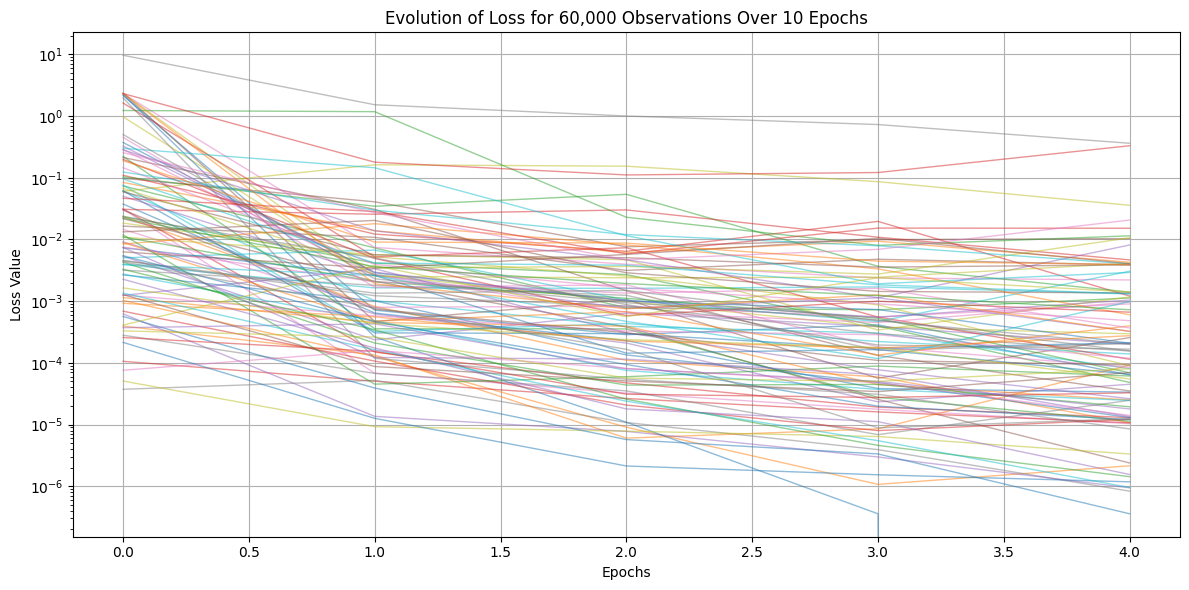

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000
print(tensor.shape)
sample_indices = np.random.choice(tensor.shape[1], size=100, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(args.iterations), sampled_tensor[:, i], alpha=0.5, linewidth=1)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [3]:
observations_losses = train_dataset.global_scores2.T.numpy()

In [ ]:


import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

